In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change.
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded.
%autoreload 2

# Смена рабочей папки.
%cd ..

d:\coding\text-proc-ml


d:\coding\text-proc-ml\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

# https://github.com/sic-rus-ai/stepik-dl-nlp/
import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()


# Data preparation

In [3]:
train_source = fetch_20newsgroups(subset="train")
test_source = fetch_20newsgroups(subset="test")

print("Train corpus len", len(train_source["data"]))
print("Test corpus len", len(test_source["data"]))
print(train_source["data"][0].strip())

print("Mark", train_source["target"][0])

Train corpus len 11314
Test corpus len 7532
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
Mark 7


In [4]:
train_source.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
for key in train_source.keys():
    print(f"{key}:")
    print(train_source[key][0])
    print("===")

data:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





===
filenames:
C:\Users\nonam\scikit_learn_data\20news_home\20news-bydate-train\rec.autos\102994
===
target_names:
alt.atheism
===
target:
7
===
DESCR:
.
===


## Features

In [6]:
train_tokenized = tokenize_corpus(train_source["data"])
test_tokenized = tokenize_corpus(test_source["data"])

print("|".join(train_tokenized[0]))

from|lerxst|wam|umd|edu|where|s|my|thing|subject|what|car|is|this|nntp|posting|host|rac3|wam|umd|edu|organization|university|of|maryland|college|park|lines|15|i|was|wondering|if|anyone|out|there|could|enlighten|me|on|this|car|i|saw|the|other|day|it|was|a|2|door|sports|car|looked|to|be|from|the|late|60s|early|70s|it|was|called|a|bricklin|the|doors|were|really|small|in|addition|the|front|bumper|was|separate|from|the|rest|of|the|body|this|is|all|i|know|if|anyone|can|tellme|a|model|name|engine|specs|years|of|production|where|this|car|is|made|history|or|whatever|info|you|have|on|this|funky|looking|car|please|e|mail|thanks|il|brought|to|you|by|your|neighborhood|lerxst


In [7]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(
    train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT
)
UNIQUE_WORDS_N = len(vocabulary)
print("Количество уникальных токенов", UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 25969
[('is', 0), ('for', 1), ('it', 2), ('that', 3), ('re', 4), ('edu', 5), ('on', 6), ('this', 7), ('have', 8), ('s', 9)]


In [8]:
word_doc_freq.shape

(25969,)

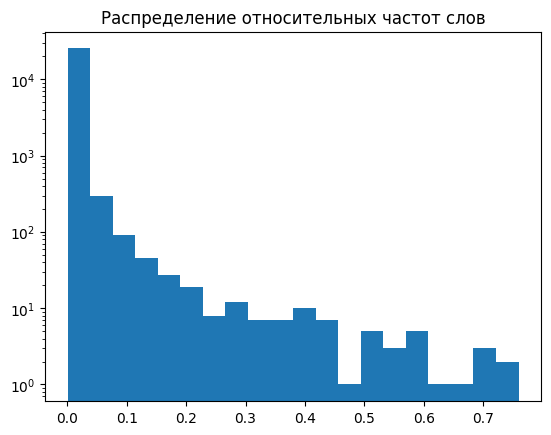

In [9]:
plt.hist(word_doc_freq, bins=20)
plt.title("Распределение относительных частот слов")
plt.yscale("log")

In [10]:
train_tokenized

[['from',
  'lerxst',
  'wam',
  'umd',
  'edu',
  'where',
  's',
  'my',
  'thing',
  'subject',
  'what',
  'car',
  'is',
  'this',
  'nntp',
  'posting',
  'host',
  'rac3',
  'wam',
  'umd',
  'edu',
  'organization',
  'university',
  'of',
  'maryland',
  'college',
  'park',
  'lines',
  '15',
  'i',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'i',
  'saw',
  'the',
  'other',
  'day',
  'it',
  'was',
  'a',
  '2',
  'door',
  'sports',
  'car',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  '60s',
  'early',
  '70s',
  'it',
  'was',
  'called',
  'a',
  'bricklin',
  'the',
  'doors',
  'were',
  'really',
  'small',
  'in',
  'addition',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  'this',
  'is',
  'all',
  'i',
  'know',
  'if',
  'anyone',
  'can',
  'tellme',
  'a',
  'model',
  'name',
  'engine',
  'specs',

In [11]:
word_doc_freq

array([7.5976664e-01, 7.3086441e-01, 7.1849036e-01, ..., 4.4193034e-04,
       4.4193034e-04, 4.4193034e-04], shape=(25969,), dtype=float32)

In [12]:
VECTORIZATION_MODE = "tfidf"
train_vectors = vectorize_texts(
    train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE
)
test_vectors = vectorize_texts(
    test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE
)

print("Размерность матрицы признаков обучающей выборки", train_vectors.shape)
print("Размерность матрицы признаков тестовой выборки", test_vectors.shape)
print()
print("Количество ненулевых элементов в обучающей выборке", train_vectors.nnz)
print(
    "Процент заполненности матрицы признаков {:.2f}%".format(
        train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])
    )
)
print()
print("Количество ненулевых элементов в тестовой выборке", test_vectors.nnz)
print(
    "Процент заполненности матрицы признаков {:.2f}%".format(
        test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])
    )
)

Размерность матрицы признаков обучающей выборки (11314, 25969)
Размерность матрицы признаков тестовой выборки (7532, 25969)

Количество ненулевых элементов в обучающей выборке 1591596
Процент заполненности матрицы признаков 0.54%

Количество ненулевых элементов в тестовой выборке 1022455
Процент заполненности матрицы признаков 0.52%


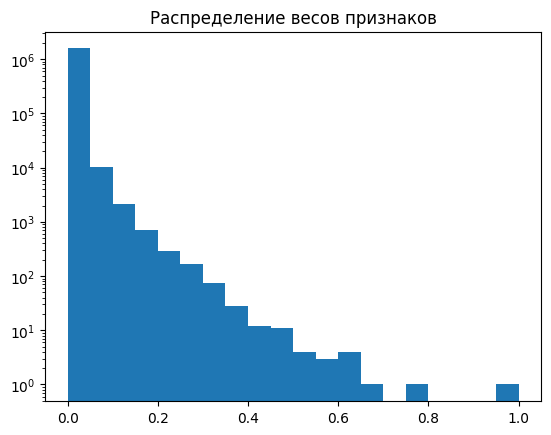

In [13]:
plt.hist(train_vectors.data, bins=20)
plt.title("Распределение весов признаков")
plt.yscale("log")

### Распределение классов

Количество уникальных меток 20


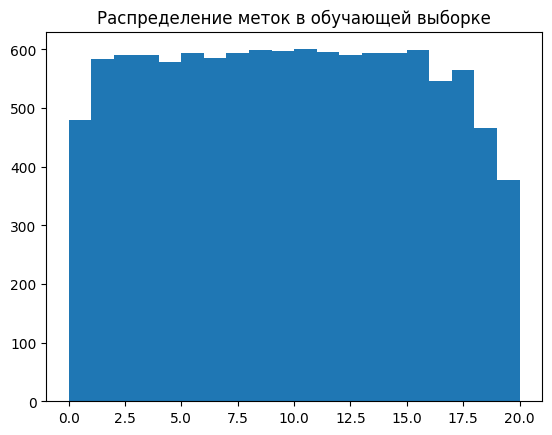

Text(0.5, 1.0, 'Распределение меток в тестовой выборке')

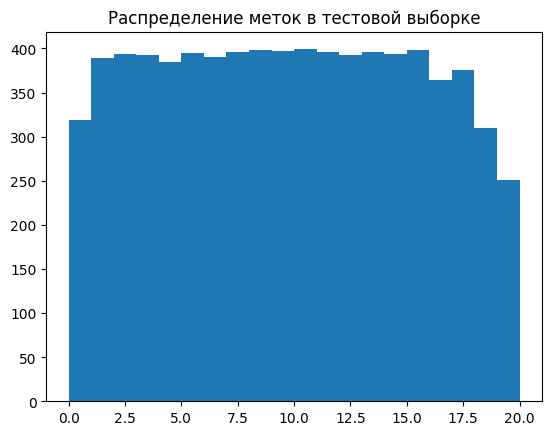

In [14]:
UNIQUE_LABELS_N = len(set(train_source["target"]))
print("Количество уникальных меток", UNIQUE_LABELS_N)

plt.hist(train_source["target"], bins=np.arange(0, 21))
plt.title("Распределение меток в обучающей выборке")
plt.show()

plt.hist(test_source["target"], bins=np.arange(0, 21))
plt.title("Распределение меток в тестовой выборке")

### pytorch

In [15]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source["target"])
test_dataset = SparseFeaturesDataset(test_vectors, test_source["target"])

In [21]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

complex_model = model = nn.Sequential(
    nn.Linear(UNIQUE_WORDS_N, 256),
    nn.ReLU(),
    nn.Dropout(0.5),  # Борьба с переобучением
    nn.LayerNorm(256),  # Нормализация
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, UNIQUE_LABELS_N),
)

scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, patience=5, factor=0.5, verbose=True
)

best_val_loss, best_model = train_eval_loop(
    model=complex_model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=1e-1,
    epoch_n=200,
    batch_size=32,
    l2_reg_alpha=0,
    lr_scheduler_ctor=scheduler,
)

Эпоха 0
Эпоха: 354 итераций, 5.76 сек
Среднее значение функции потерь на обучении 3.2536865553613437
Среднее значение функции потерь на валидации 3.008578327752776
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 5.39 сек
Среднее значение функции потерь на обучении 3.010303747182512
Среднее значение функции потерь на валидации 3.013577252121295

Эпоха 2
Эпоха: 354 итераций, 6.03 сек
Среднее значение функции потерь на обучении 3.0097212697153037
Среднее значение функции потерь на валидации 3.01163860296799

Эпоха 3
Эпоха: 354 итераций, 5.75 сек
Среднее значение функции потерь на обучении 3.0093978690562273
Среднее значение функции потерь на валидации 3.002315034300594
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 5.74 сек
Среднее значение функции потерь на обучении 3.0090241890169134
Среднее значение функции потерь на валидации 3.011713082507505

Эпоха 5
Эпоха: 354 итераций, 5.82 сек
Среднее значение функции потерь на обучении 3.010418013664289
Среднее значение функции потерь на 

In [17]:
b_size = (12 * (10**9) * 100) / (0.5)
b_size / (1024**2)

2288818.359375

### Оценка качества

In [22]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(
    torch.from_numpy(train_pred), torch.from_numpy(train_source["target"]).long()
)

print("Среднее значение функции потерь на обучении", float(train_loss))
print(
    "Доля верных ответов", accuracy_score(train_source["target"], train_pred.argmax(-1))
)
print()


test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(
    torch.from_numpy(test_pred), torch.from_numpy(test_source["target"]).long()
)

print("Среднее значение функции потерь на валидации", float(test_loss))
print(
    "Доля верных ответов", accuracy_score(test_source["target"], test_pred.argmax(-1))
)

100%|██████████| 354/353.5625 [00:01<00:00, 306.57it/s]


Среднее значение функции потерь на обучении 2.9902522563934326
Доля верных ответов 0.0530316422131872



236it [00:00, 312.84it/s]                             

Среднее значение функции потерь на валидации 2.990264654159546
Доля верных ответов 0.05297397769516728


Модель без изменений:  
100%|██████████| 354/353.5625 [00:00<00:00, 527.96it/s]
Среднее значение функции потерь на обучении 0.021407494321465492
Доля верных ответов 0.9992929114371575

236it [00:00, 526.34it/s]                             
Среднее значение функции потерь на валидации 0.825456440448761
Доля верных ответов 0.7932819968135953

Модель с dropout
100%|██████████| 354/353.5625 [00:01<00:00, 306.57it/s]
Среднее значение функции потерь на обучении 2.9902522563934326
Доля верных ответов 0.0530316422131872

236it [00:00, 312.84it/s]                             
Среднее значение функции потерь на валидации 2.990264654159546
Доля верных ответов 0.05297397769516728
Больше эпох, размер батча, аугментация

### scikit-learn realization

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline(
    (
        (
            "vect",
            TfidfVectorizer(
                tokenizer=tokenize_text_simple_regex, max_df=MAX_DF, min_df=MIN_COUNT
            ),
        ),
        ("cls", LogisticRegression()),
    )
)
sklearn_pipeline.fit(train_source["data"], train_source["target"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=5,
                                 tokenizer=<function tokenize_text_simple_regex at 0x0000020C6F4FD630>)),
                ('cls', LogisticRegression())])

In [20]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source["data"])
sklearn_train_loss = F.cross_entropy(
    torch.from_numpy(sklearn_train_pred), torch.from_numpy(train_source["target"])
)
print("Среднее значение функции потерь на обучении", float(sklearn_train_loss))
print(
    "Доля верных ответов",
    accuracy_score(train_source["target"], sklearn_train_pred.argmax(-1)),
)
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source["data"])
sklearn_test_loss = F.cross_entropy(
    torch.from_numpy(sklearn_test_pred), torch.from_numpy(test_source["target"])
)
print("Среднее значение функции потерь на валидации", float(sklearn_test_loss))
print(
    "Доля верных ответов",
    accuracy_score(test_source["target"], sklearn_test_pred.argmax(-1)),
)

Среднее значение функции потерь на обучении 2.4914053103177123
Доля верных ответов 0.9679158564610217

Среднее значение функции потерь на валидации 2.64414555764586
Доля верных ответов 0.8252788104089219
